# JupyterLab environment

This is the JupyterLab environment containing materials for the *Ab Initio methods* lecture. The environment contains live examples and lecture materials. The document you are reading right now is a **notebook** containig text (like this one) and code **cells**. Each cell can be edited (double click on it or select it and press `Enter`. After editing the cell can be *rendered* (text cell) or *executed* (code cell) by pressing `Shift Enter`. The code cells contain Python code. Fluent knowledge of the python language is not required for understanding of these examples. `Help` menu on the top bar contains links to manuals for Jupyter environment list of keyboard shortcuts, Python language reference (including beginners guide), and manuals for useful function libraries for plotting (Matplotlib) numerical computation (NumPy) varius scientific algorithms (SciPy). Python and JupyterLab references are already opened on the right portion of the screan. The dynamical help panel in the top right corner shows information about objects under the cursor in the notebook.

Explore the environement - **you cannot break anything**. If you mess something up you can just close the browser tab and start over from the beginning. 

**The files are not persistent!** - if you want ot save your work you need to download it to your own machine (right click on the file in the browser on the left and select "download")

# Hydrogen molecule with DFT

The calculation starts with importing necassary tools for the calculation

In [2]:
# Command importing plotting and numerical functions
%pylab inline

# Atomic Simulation Environment tools
from ase import Atoms                      # Object representing groups of atoms
from ase.units import Ry, Bohr             # Unit conversion constants
from ase.calculators.abinit import Abinit  # AbInit DFT program interface
from ase.visualize.plot import plot_atoms  # Simple plotting function

Populating the interactive namespace from numpy and matplotlib


### Construction of the molecule

Here we build the H$_2$ molecule inside a 10x10x10 Angstrom box. The atoms are separated by 1A distance. We check the result by simple plot.

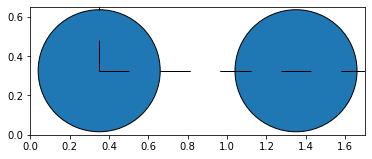

In [3]:
H2 = Atoms("H2", positions=[(0,0,0),(1,0,0)], cell=[10, 10, 10])
plot_atoms(H2, colors=2*['C0'], show_unit_cell=1);

### Defining DFT calculator

Define the AbInit calculator object with all required parameters:

* `label` name
* `nbands` number of electronic bands per atom
* `ecut` cutoff energy for the plane wave representation of wavefunctions
* `kpts` grid of k-points for reciprocal space integrations
* `toldfe` convergence cryterion for electronic states iteration

The variables marked with double exclamation points (!!) are critical for the accuracy or sometimes even validity of the results. After defining the calculator we assign it to the H2 molecule defined above. The parameters used here are optimized for speed *not* accuracy.

In [14]:
calc = Abinit(label='h2',
              nbands=2,           # !!
              ecut= 8 * Ry,       # !! 
              kpts=[1, 1, 1],     # !!
              toldfe=1.0e-3,      # !!
              xc='PBE',           # try 'PBE'
              pps='hgh',
              directory="work",
              v8_legacy_format=True
              )

H2.set_calculator(calc)

Finally, we can run a simple calculation of total energy of the H2 molecule.

In [15]:
H2.get_potential_energy()

-28.648537811351922

## Calculation of H2 bond length

To calculate the equilibrium bond length of the molecule we need to plot energy (`E`)
of the molecule for several H-H distances `d` and find its minimum by fitting the 4$^{th}$ order polynomial to the data points and locating its minimum by findig root of the derivative.

First we calculate, for few distances `d` in the range 1-2A, energies `E` and forces `F` and put them in two lists `EvsD` and `FvsD` respectively.

In [16]:
EvsD = []
FvsD = []
print('   d      E      F\n---------------------')
for d in np.linspace(1, 2, 7):
    H2.set_positions([(0,0,0),(0,0,d*Bohr)])
    E = H2.get_potential_energy()
    F = H2.get_forces()[0,2]
    EvsD.append([d, E])
    FvsD.append([d, F])
    print(f'{d:5.2f}: {E:6.2f} {F:6.2f}')

   d      E      F
---------------------
 1.00: -26.17 -28.11
 1.17: -27.99 -14.30
 1.33: -28.86  -6.11
 1.50: -29.17  -1.29
 1.67: -29.15   1.45
 1.83: -28.94   2.91
 2.00: -28.65   3.62


Reorganize the lists into a matrix (array) for easier manipulation.

In [17]:
FvsD = np.array(FvsD).T
EvsD = np.array(EvsD).T

### Find E(d) minimum

Fit the fourth order polynomial to the data and find its minimum by finding root of its derivative. The derivative is calculated by standard formula for polynomials. We select a real root between 0.5 and 1. We use here a compact form of iteration known in python as *list comprehensions*.

In [18]:
fit = polyfit(EvsD[0]*Bohr, EvsD[1], 4)

mpos = [real(r) for r in roots(fit[:-1] * np.arange(4,0,-1)) 
        if abs(imag(r))<1e-3 and real(r) < 1 and real(r) > 0.5][0]

Finally we plot everything on the simple graph.

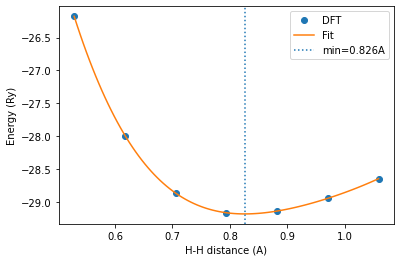

In [19]:
plot(EvsD[0]*Bohr, EvsD[1], "o", label='DFT')
d = linspace(1*Bohr,2*Bohr,100)
plot(d, np.polyval(fit, d), "-", label='Fit')
axvline(mpos, ls=':', label=f'min={mpos:.3f}A')
xlabel('H-H distance (A)')
ylabel('Energy (Ry)')
legend();

### Find F(d)=0

Alternatively, we can find the place where interatomic forces in the molecule cross zero. We have already calculated the forces with energy. We only need to fit another polynomial and find its real root in the (0.5, 1) A range.

In [20]:
fit = np.polyfit(FvsD[0]*Bohr, FvsD[1], 4)

mpos = [np.real(r) for r in np.roots(fit) 
        if abs(np.imag(r))<1e-3 and real(r) < 1 and real(r) > 0.5][0]

Plot the results

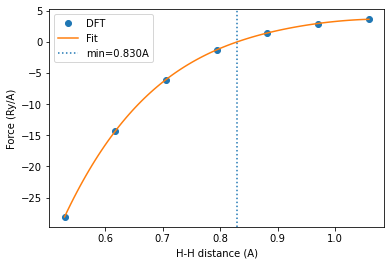

In [21]:
plot(FvsD[0]*Bohr, FvsD[1], "o", label="DFT")
d = linspace(1*Bohr,2*Bohr,100)
plot(d, np.polyval(fit, d), "-", label="Fit")
axvline(mpos, ls=':', label=f'min={mpos:.3f}A')
xlabel('H-H distance (A)')
ylabel('Force (Ry/A)')
legend();